# Very Simple IEMM Example

This notebook demonstrates the basic usage of the IEMM (Imprecise Ensemble of Maximum Margin) library with a simple 2D clustering example.

In [370]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from evclust.ecm import ecm
from iemm import IEMM, Loss

import seaborn as sns

In [371]:
# Configure output folder and saving helpers
import os
from pathlib import Path

output_dir = Path("figures_illustrative_example")
output_dir.mkdir(parents=True, exist_ok=True)


def save_fig(fig, name: str, tight: bool = True):
    path = output_dir / f"{name}.pdf"
    if tight:
        fig.savefig(path, bbox_inches="tight")
    else:
        fig.savefig(path)
    print(f"Saved figure to {path}")


def save_diagram(diagram, name: str):
    path = output_dir / f"{name}.pdf"
    try:
        # schemdraw Drawing supports .save
        diagram.save(str(path))
        print(f"Saved diagram to {path}")
    except Exception as e:
        # Fallback for graphviz-like objects
        if hasattr(diagram, "render"):
            out = diagram.render(filename=str(path.with_suffix("")), format="pdf", cleanup=True)
            print(f"Saved diagram to {out}")
        else:
            raise


In [372]:
# Suppress deprecated pandas option FutureWarning and sanitize data
import warnings
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=r".*use_inf_as_na.*"
)

# Helper function (optional) to replace inf values globally after loading data later
import numpy as np
import pandas as pd

def replace_inf(df: pd.DataFrame) -> pd.DataFrame:
    return df.replace([np.inf, -np.inf], np.nan)


## Load and Prepare Data

We'll use a simple synthetic dataset with 2D features for easy visualization.

In [373]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fedesoriano/body-fat-prediction-dataset")

print("Path to dataset files:", path)

# Load dataset
data = pd.read_csv(f"{path}/bodyfat.csv").iloc[:, 5:]  # Skip first five columns

Path to dataset files: /Users/victor/.cache/kagglehub/datasets/fedesoriano/body-fat-prediction-dataset/versions/1


In [374]:
data

,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7
...,...,...,...,...,...,...,...,...,...,...
247,34.9,89.2,83.6,88.8,49.6,34.8,21.5,25.6,25.7,18.5
248,40.9,108.5,105.0,104.5,59.6,40.8,23.2,35.2,28.6,20.1
249,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.0
250,38.9,108.3,101.3,97.8,56.0,41.6,22.7,30.5,29.4,19.8


Saved figure to figures_illustrative_example/histograms_raw.pdf


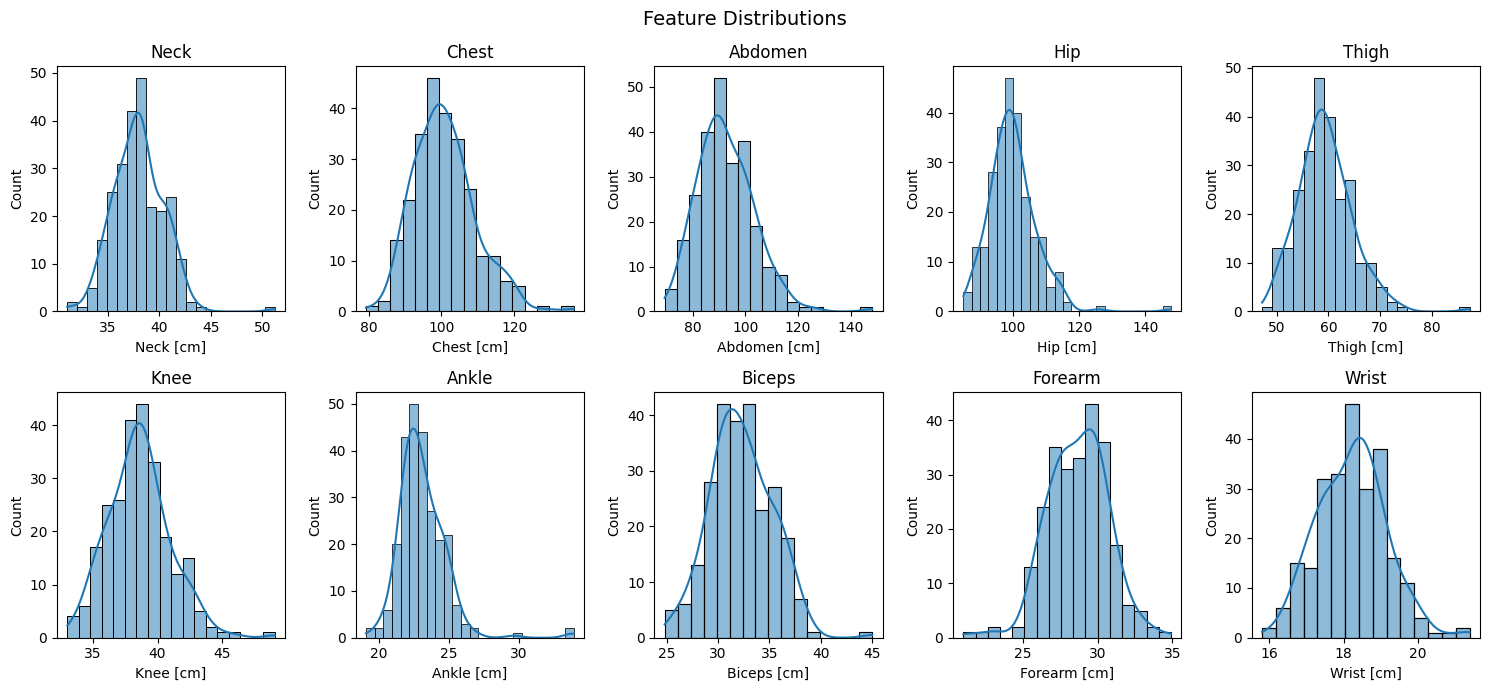

In [375]:
# sns histograms, figure with 3 columns and 5 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 7))
axes = axes.flatten()
for i, column in enumerate(data.columns):
    to_plot = data[column]
    to_plot.name = column + " [cm]"
    sns.histplot(to_plot, ax=axes[i], kde=True)
    axes[i].set_title(column)
fig.suptitle("Feature Distributions", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
save_fig(fig, "histograms_raw")
plt.show()

In [376]:
features = data.values
feature_names = data.columns.to_list()

print(f"Dataset shape: {features.shape}")
print(f"Feature names: {feature_names}")

Dataset shape: (252, 10)
Feature names: ['Neck', 'Chest', 'Abdomen', 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Forearm', 'Wrist']


In [377]:
# normalize features to [0, 1]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features)

## Create Initial Clustering with ECM

We use the Evidential C-Means (ECM) algorithm to create an initial credal partition.

In [378]:
# Apply ECM clustering
number_clusters = 2
model = ecm(x=features_normalized, c=number_clusters, beta=2, alpha=1, delta=3, disp=False)

# Extract mass functions and focal sets
mass = model['mass_n']
Ynd = model['Ynd']
F = model['F'][1:]  # Remove the first element (empty set)

print(f"Number of data points: {mass.shape[0]}")
print(f"Number of focal sets: {mass.shape[1]}")
print(f"Focal sets F: {F}")

Number of data points: 252
Number of focal sets: 3
Focal sets F: [[1. 0.]
 [0. 1.]
 [1. 1.]]


## Visualize the Initial Clustering

In [379]:
# points_colors = mass @ np.array(metacluster_colors)

In [380]:
# get 
focal_sets_names = [" or ".join([str(i+1) for i in range(len(f)) if f[i] == 1]) for f in F]
focal_sets_names

['1', '2', '1 or 2']

In [381]:
predicted_metaclusters = []
for y in Ynd:
    for idx, f in enumerate(F):
        if np.array_equal(y, f):
            predicted_metaclusters.append(focal_sets_names[idx])
            break

In [382]:
# clusters_colors = sns.color_palette("pastel", F.shape[1])
# clusters_colors

# metacluster_colors = ((F/F.sum(axis=1, keepdims=True)) @ clusters_colors)
# metacluster_colors = np.clip(metacluster_colors, 0, 1)
# metacluster_colors

In [383]:
metacluster_colors = sns.color_palette("Set1", F.shape[0])
metacluster_colors

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726)]

In [384]:
data_labeled = data.copy()
data_labeled['Predicted Metacluster'] = predicted_metaclusters

Saved figure to figures_illustrative_example/histograms_by_metacluster.pdf


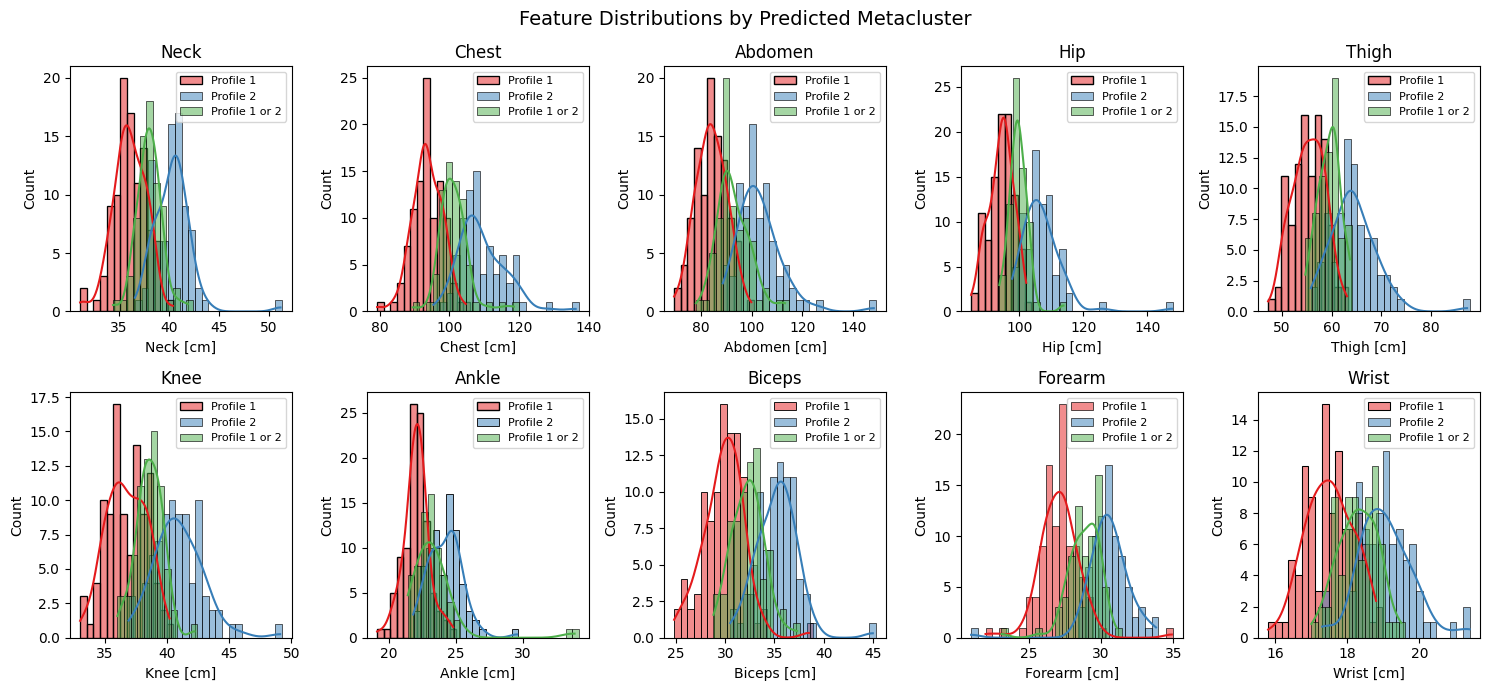

In [385]:
# sns histograms, figure with 5 columns and 3 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 7))
axes = axes.flatten()
for feature_idx, column in enumerate(data.columns):
    bin_width = (data[column].max() - data[column].min()) / 30    
    for idx_metacluster, metacluster in enumerate(focal_sets_names):
        subset = data_labeled[data_labeled['Predicted Metacluster'] == metacluster]
        color = metacluster_colors[idx_metacluster]
        to_plot = subset[column]
        to_plot.name = column + " [cm]"
        sns.histplot(to_plot, ax=axes[feature_idx], binwidth=bin_width, kde=True, color=color, edgecolor='black', label=f'Profile {metacluster}')
    axes[feature_idx].set_title(column)
    axes[feature_idx].legend(fontsize=8)
fig.suptitle("Feature Distributions by Predicted Metacluster", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
save_fig(fig, "histograms_by_metacluster")
plt.show()

## Apply IEMM Classification

Now we'll use the IEMM classifier to create decision boundaries.

In [386]:
def create_and_fit_iemm_classifier(lambda_mistakeness):
    classifier = IEMM(lambda_mistakeness=lambda_mistakeness)
    classifier.fit(features, mass, F)

    print(f"IEMM classifier trained with lambda = {lambda_mistakeness}")

    # Generate decision tree diagram
    diagram = classifier.plot_tree(
        cluster_names=focal_sets_names,
        feature_names=feature_names,
        focal_colors=metacluster_colors
    )
    # Display the decision tree
    display(diagram)

    # Save the decision tree diagram as PDF
    try:
        save_diagram(diagram, f"iemm_tree_lambda_{lambda_mistakeness:.1f}")
    except Exception as e:
        print(f"Warning: failed to save diagram PDF: {e}")

    classififier_predict = classifier.predict(features)
    classififier_predict = [focal_sets_names[p] for p in classififier_predict]

    data_labeled['IEMM, lambda=%.1f' % lambda_mistakeness] = classififier_predict

    # Histograms for predicted profiles
    fig, axes = plt.subplots(2, 5, figsize=(15, 7))
    axes = axes.flatten()
    for feature_idx, column in enumerate(data.columns):
        bin_width = (data[column].max() - data[column].min()) / 30        
        for idx, metacluster in enumerate(focal_sets_names):
            subset = data_labeled[data_labeled['IEMM, lambda=%.1f' % lambda_mistakeness] == metacluster]
            to_plot = subset[column]
            to_plot.name = column + " [cm]"
            sns.histplot(
                to_plot,
                ax=axes[feature_idx],
                binwidth=bin_width,
                kde=True,
                color=metacluster_colors[idx],
                edgecolor='black',
                label=f'Profile {metacluster}'
            )
        axes[feature_idx].set_title(column)
        axes[feature_idx].legend(fontsize=8)
    fig.suptitle(f"Feature Distributions (IEMM, $\lambda={lambda_mistakeness:.1f}$)", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    save_fig(fig, f"histograms_iemm_lambda_{lambda_mistakeness:.1f}")
    plt.show()

## Generate Decision Tree Visualization

IEMM can also generate interpretable decision trees.

IEMM classifier trained with lambda = 0.0


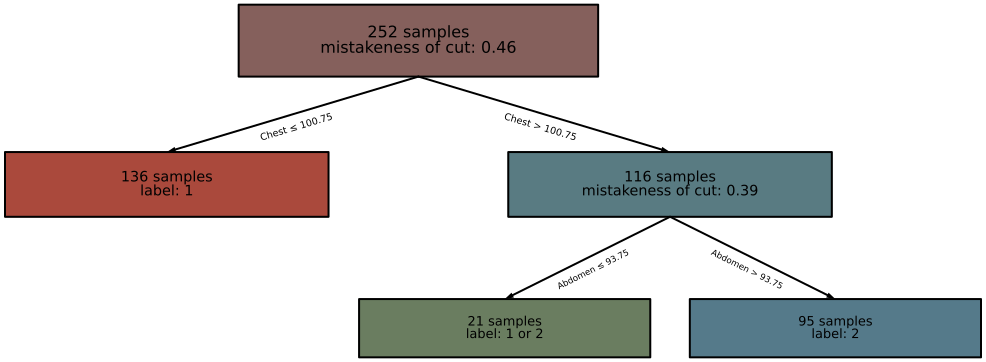

Saved diagram to figures_illustrative_example/iemm_tree_lambda_0.0.pdf
Saved figure to figures_illustrative_example/histograms_iemm_lambda_0.0.pdf
Saved figure to figures_illustrative_example/histograms_iemm_lambda_0.0.pdf


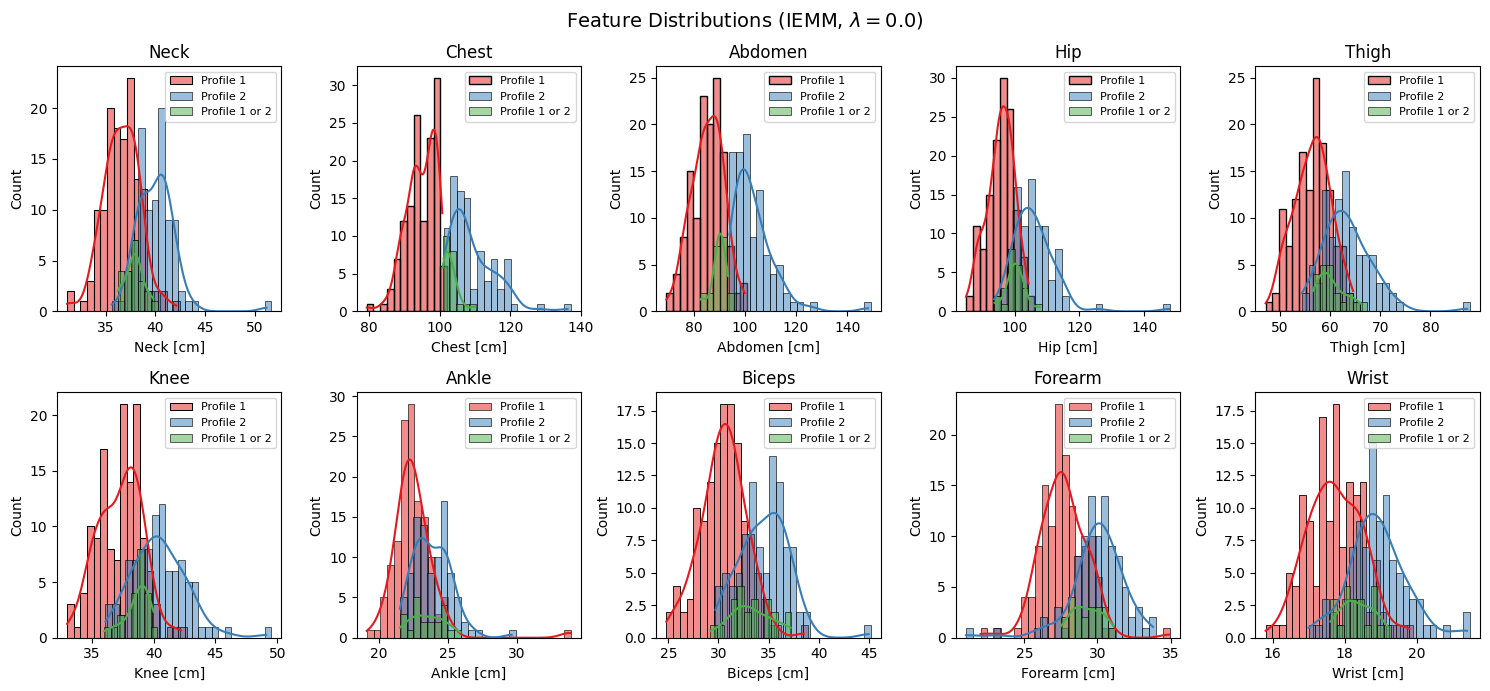

In [387]:
create_and_fit_iemm_classifier(0.0)

IEMM classifier trained with lambda = 1.0


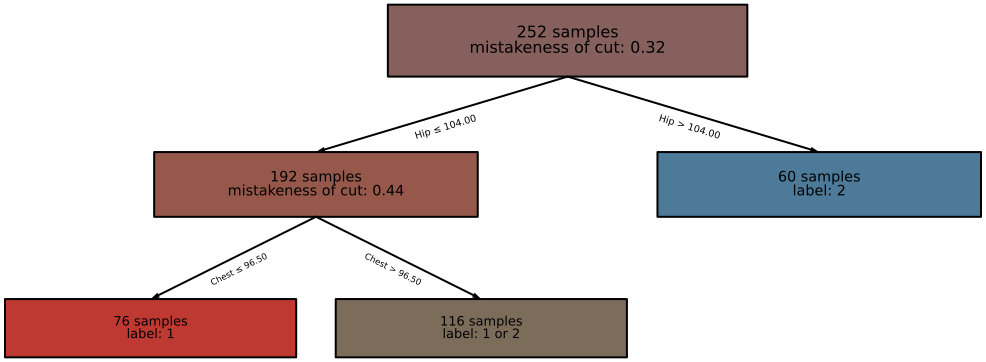

Saved diagram to figures_illustrative_example/iemm_tree_lambda_1.0.pdf
Saved figure to figures_illustrative_example/histograms_iemm_lambda_1.0.pdf
Saved figure to figures_illustrative_example/histograms_iemm_lambda_1.0.pdf


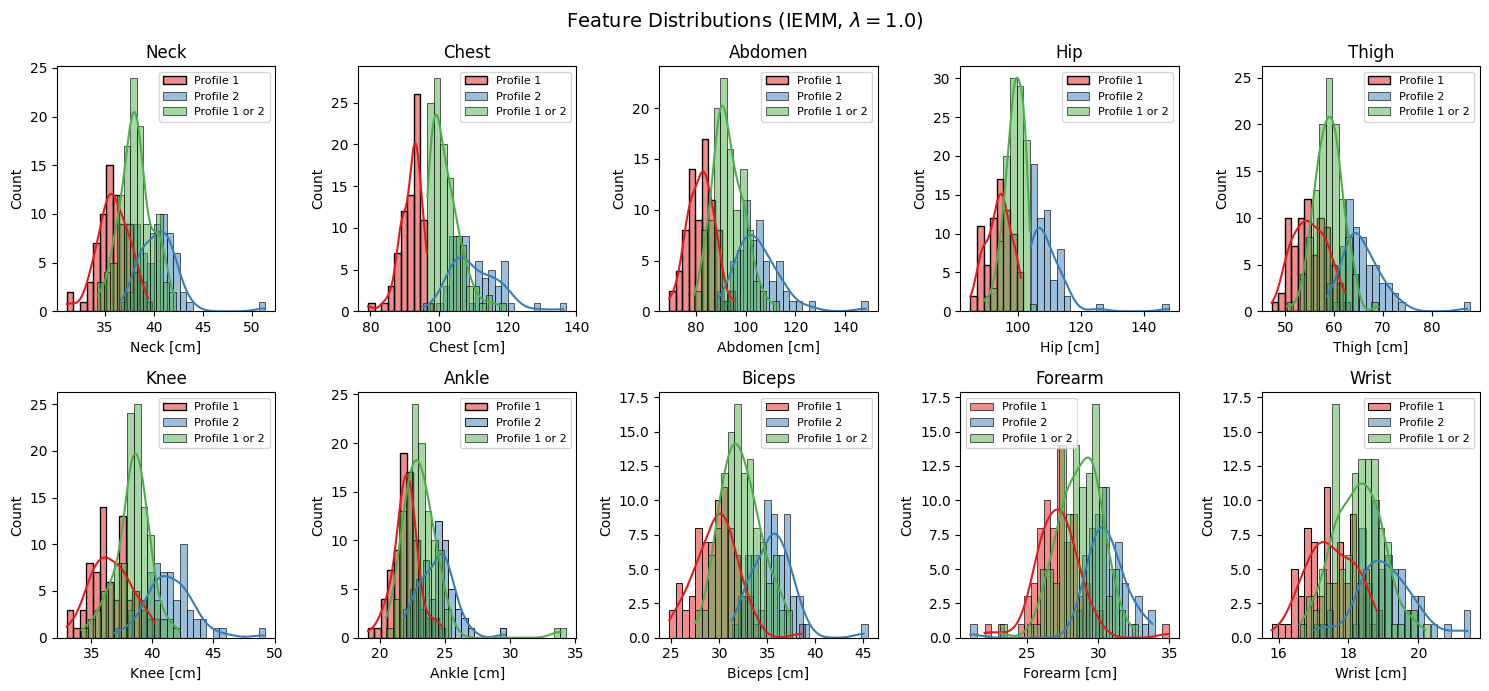

In [388]:
create_and_fit_iemm_classifier(1.0)

IEMM classifier trained with lambda = -1.0


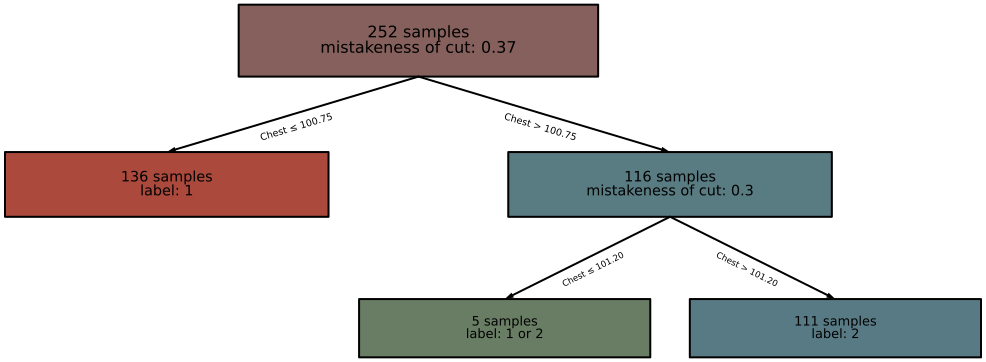

Saved diagram to figures_illustrative_example/iemm_tree_lambda_-1.0.pdf
Saved figure to figures_illustrative_example/histograms_iemm_lambda_-1.0.pdf
Saved figure to figures_illustrative_example/histograms_iemm_lambda_-1.0.pdf


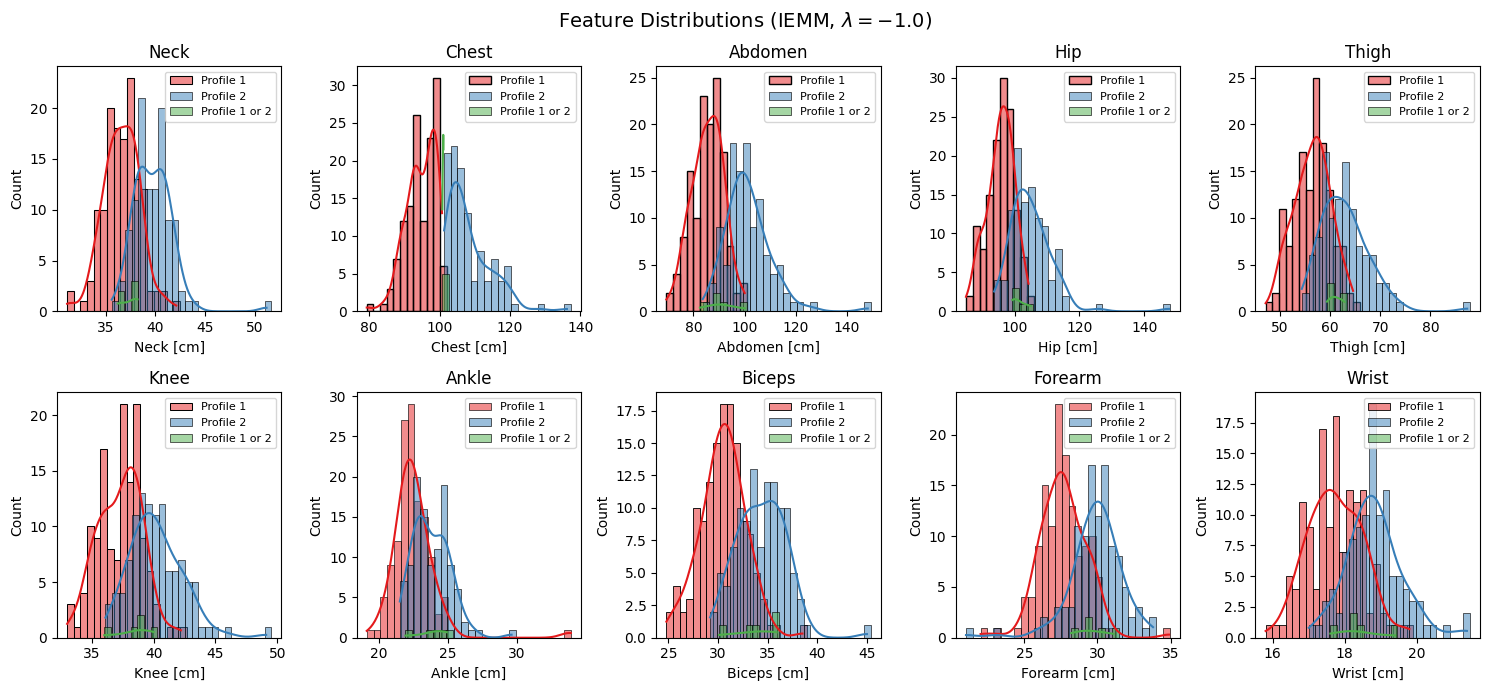

In [389]:
create_and_fit_iemm_classifier(-1.0)